<a href="https://colab.research.google.com/github/aaronblanco/TDI/blob/main/Practica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practica 1 TDI

1️⃣ Cargar los datasets


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.impute import SimpleImputer

In [73]:
from google.colab import drive
drive.mount('/content/drive')

FILES = {
    'edstays': '/content/drive/MyDrive/edstays.csv.gz',
    'diagnosis': '/content/drive/MyDrive/diagnosis.csv.gz',
    'medrecon': '/content/drive/MyDrive/medrecon.csv.gz',
    'pyxis': '/content/drive/MyDrive/pyxis.csv.gz',
    'triage': '/content/drive/MyDrive/triage.csv.gz',
    'vitalsign': '/content/drive/MyDrive/vitalsign.csv.gz'
}

# Assuming DATA_DIR is defined elsewhere or needs to be defined
# For now, let's assume DATA_DIR is the directory containing the unzipped files
DATA_DIR = '/content/datos'

missing = [f for f in FILES.values() if not (Path(f).exists())] # Check existence using full path
if missing:
    print('Faltan archivos en Google Drive:') # Updated message
    for m in missing:
        print('-', m)
else:
    print('Todos los ficheros encontrados en Google Drive.') # Updated message
    print('Tamaños:')
df_edstays = pd.read_csv(FILES['edstays'], compression='gzip')
df_diagnosis = pd.read_csv(FILES['diagnosis'], compression='gzip')
df_triage = pd.read_csv(FILES['triage'], compression='gzip')
df_vitalsign = pd.read_csv(FILES['vitalsign'], compression='gzip')
df_medrecon = pd.read_csv(FILES['medrecon'], compression='gzip')
df_pyxis = pd.read_csv(FILES['pyxis'], compression='gzip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Todos los ficheros encontrados en Google Drive.
Tamaños:


In [74]:
# agrupa df_diagnosis por stay_id

# Implementa aquí la agregación
df_diag_grouped = df_diagnosis.groupby('stay_id')['icd_code'].agg(list).reset_index()


In [75]:
# Implementa agrupaciones
agg_map = {'temperature': 'mean', 'heartrate': 'max', 'o2sat': 'min', 'sbp': 'max', 'dbp': 'max'}

triage_cols = [col for col in agg_map.keys() if col in df_triage.columns]
vitals_cols = [col for col in agg_map.keys() if col in df_vitalsign.columns]

triage_agg_map = {col: agg_map[col] for col in triage_cols}
vitals_agg_map = {col: agg_map[col] for col in vitals_cols}


triage_grp = df_triage.groupby('stay_id').agg(triage_agg_map).reset_index()
vitals_grp = df_vitalsign.groupby('stay_id').agg(vitals_agg_map).reset_index()

# Renombrar columnas agregadas para evitar conflictos
triage_grp.rename(columns={'temperature': 'temperature_c_triage_mean', 'heartrate': 'heartrate_triage_max', 'o2sat': 'o2sat_triage_min', 'sbp': 'sbp_triage_max', 'dbp': 'dbp_triage_max'}, inplace=True)
vitals_grp.rename(columns={'temperature': 'temperature_c_vitals_mean', 'heartrate': 'heartrate_vitals_max', 'o2sat': 'o2sat_vitals_min', 'sbp': 'sbp_vitals_max', 'dbp': 'dbp_vitals_max'}, inplace=True)

# Fusionar los dataframes agrupados con df_merged

df_merged = df_edstays.copy()

merged = df_merged.merge(triage_grp, on='stay_id', how='left')
merged = merged.merge(vitals_grp, on='stay_id', how='left')

merged = merged.merge(df_diag_grouped, on='stay_id', how='left')
merged.drop(columns=['subject_id'], inplace=True)
print('Merged shape:', merged.shape)

Merged shape: (222, 19)


In [81]:
# Agrupar df_medrecon por stay_id y agregar ndc y gsn como listas únicas
df_medrecon_agg = df_medrecon.groupby('stay_id').agg({
    'ndc': lambda x: list(x.dropna().unique()),
    'gsn': lambda x: list(x.dropna().unique())
}).reset_index()

# Agrupar df_pyxis por stay_id y agregar gsn como lista única
df_pyxis_agg = df_pyxis.groupby('stay_id').agg({
    'gsn': lambda x: list(x.dropna().unique())
}).reset_index()

# Fusionar los dataframes agregados con merged
merged = merged.merge(df_medrecon_agg, on='stay_id', how='left', suffixes=('', '_medrecon_agg'))
merged = merged.merge(df_pyxis_agg, on='stay_id', how='left', suffixes=('', '_pyxis_agg'))

# Eliminar columnas duplicadas que puedan haber resultado de las fusiones (si las hay)
merged = merged.loc[:,~merged.columns.duplicated()]

print('Resultado final del merge con medrecon y pyxis agregados:')
print(merged.shape)
print(merged)

Resultado final del merge con medrecon y pyxis agregados:
(222, 29)
        hadm_id   stay_id               intime              outtime gender  \
0    23300884.0  37887480  2125-03-19 12:36:00  2125-03-19 16:59:47      F   
1    26706939.0  34176810  2154-02-05 17:09:00  2154-02-05 22:54:00      F   
2           NaN  32103106  2154-08-03 15:31:00  2154-08-03 22:29:00      F   
3    27984218.0  38797992  2153-02-12 21:59:00  2153-02-13 01:38:00      F   
4    27993466.0  33473053  2137-06-12 16:54:00  2137-06-12 18:37:22      F   
..          ...       ...                  ...                  ...    ...   
217  22995465.0  31628990  2174-05-26 04:20:00  2174-05-26 09:18:00      M   
218  28723315.0  32405286  2141-08-12 12:08:00  2141-08-12 17:20:00      M   
219  22081550.0  34391979  2186-11-12 16:09:00  2186-11-12 19:55:00      M   
220         NaN  34161260  2183-12-02 18:06:00  2183-12-03 00:30:00      M   
221  24470193.0  35470228  2137-10-08 18:16:00  2137-10-08 21:20:50      M

In [77]:
# Crear variables derivadas en el DataFrame 'merged'

# 'fiebre': Temperatura > 37.5
# Usaremos las columnas agregadas de temperatura, dando prioridad a vitalsign si ambas existen
merged['fiebre'] = ((merged['temperature_c_vitals_mean'] > 37.5) | (merged['temperature_c_triage_mean'] > 37.5)).astype(int)

# 'taquicardia': heartrate > 100
# Usaremos las columnas agregadas de heartrate, dando prioridad a vitalsign si ambas existen
merged['taquicardia'] = ((merged['heartrate_vitals_max'] > 100) | (merged['heartrate_triage_max'] > 100)).astype(int)


# 'hipoxia': o2sat < 92
# Usaremos las columnas agregadas de o2sat, dando prioridad a vitalsign si ambas existen
merged['hipoxia'] = ((merged['o2sat_vitals_min'] < 92) | (merged['o2sat_triage_min'] < 92)).astype(int)


# 'icd_principal': El primer código ICD en la lista de icd_code
# Manejar casos donde la lista puede estar vacía o ser NaN
merged['icd_principal'] = merged['icd_code'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# 'diagnóstico complejo': Número de diagnósticos > 3
# Manejar casos donde la lista puede estar vacía o ser NaN
merged['num_diagnosticos'] = merged['icd_code'].apply(lambda x: len(x) if isinstance(x, list) else 0)
merged['diagnóstico complejo'] = (merged['num_diagnosticos'] > 3).astype(int)
merged = merged.drop(columns=['num_diagnosticos']) # Drop the intermediate column

print('DataFrame con variables derivadas actualizadas:')


DataFrame con variables derivadas actualizadas:


3️⃣ Procesamiento de variables

Ejemplo:


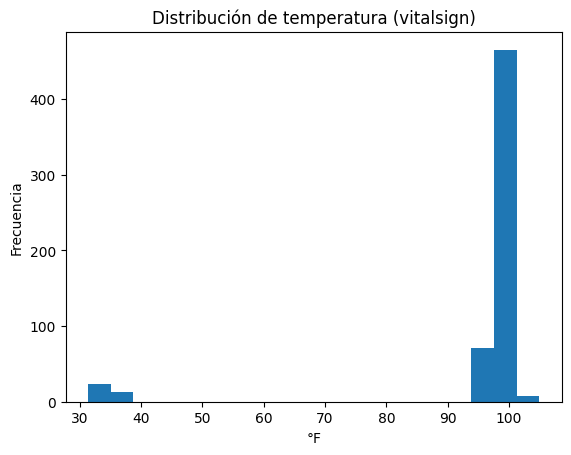

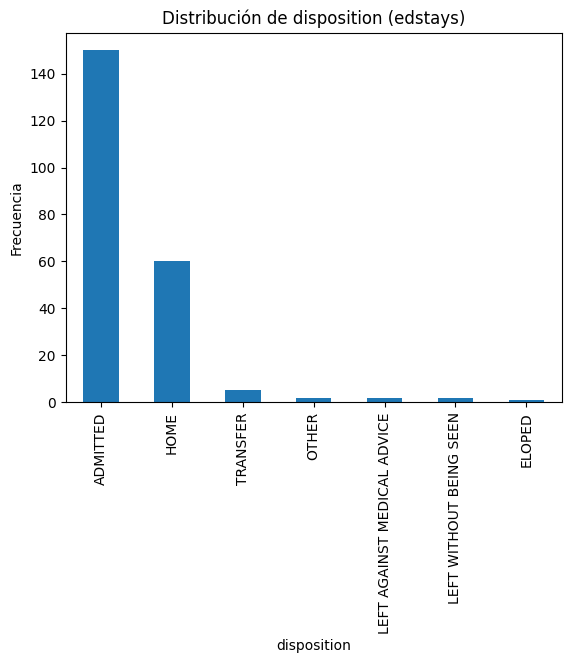

In [78]:

if 'temperature' in df_vitalsign.columns:
    plt.hist(df_vitalsign['temperature'].dropna(), bins=20)
    plt.title('Distribución de temperatura (vitalsign)')
    plt.xlabel('°F')
    plt.ylabel('Frecuencia')
    plt.show()

if 'disposition' in df_edstays.columns:
    df_edstays['disposition'].value_counts().plot(kind='bar')
    plt.title('Distribución de disposition (edstays)')
    plt.ylabel('Frecuencia')
    plt.show()

🧠 Ejercicio 2



1.   Limpieza de valores nulos o atípicos.
2.   Visualización básica (histograma, boxplot o conteo de categorías).
3. Breve comentario sobre lo que observas.



In [79]:

def detect_outliers_iqr(df_in, features, k=1.5):
    out_idx = set()
    for col in features:
        Q1 = df_in[col].quantile(0.25)
        Q3 = df_in[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        ids = df_in[(df_in[col] < lower) | (df_in[col] > upper)].index
        out_idx.update(ids.tolist())
    return sorted(list(out_idx))


In [80]:
# Seleccionar solo columnas numéricas para la detección de valores atípicos
numeric_cols = merged.select_dtypes(include=np.number).columns.tolist()

# Excluir stay_id y hadm_id si son numéricos pero no representan medidas
cols_to_exclude = ['stay_id', 'hadm_id']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print(detect_outliers_iqr(merged, numeric_cols))

[0, 2, 3, 5, 6, 12, 14, 15, 17, 18, 20, 24, 29, 37, 38, 41, 43, 44, 45, 46, 47, 53, 54, 56, 59, 60, 64, 72, 74, 75, 79, 80, 81, 83, 90, 91, 93, 95, 97, 99, 100, 101, 103, 108, 113, 116, 118, 121, 122, 123, 124, 126, 129, 130, 131, 134, 136, 141, 148, 149, 150, 151, 152, 153, 154, 157, 158, 160, 161, 162, 163, 168, 169, 175, 176, 180, 183, 185, 190, 192, 194, 196, 197, 199, 200, 202, 204, 208, 210, 216, 217, 218, 219, 221]


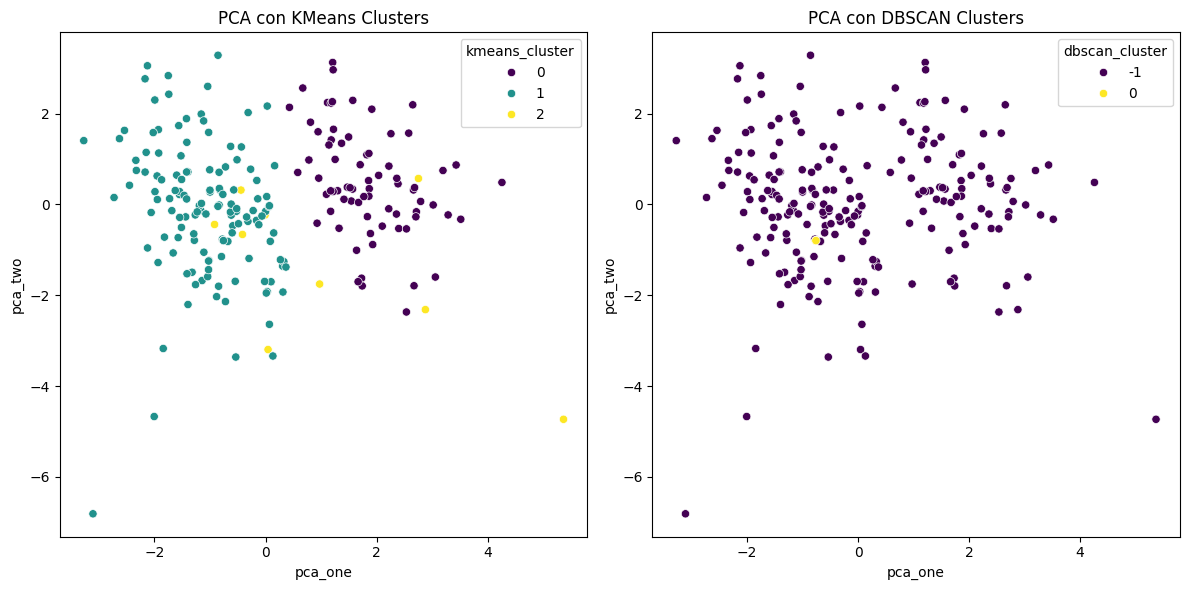

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


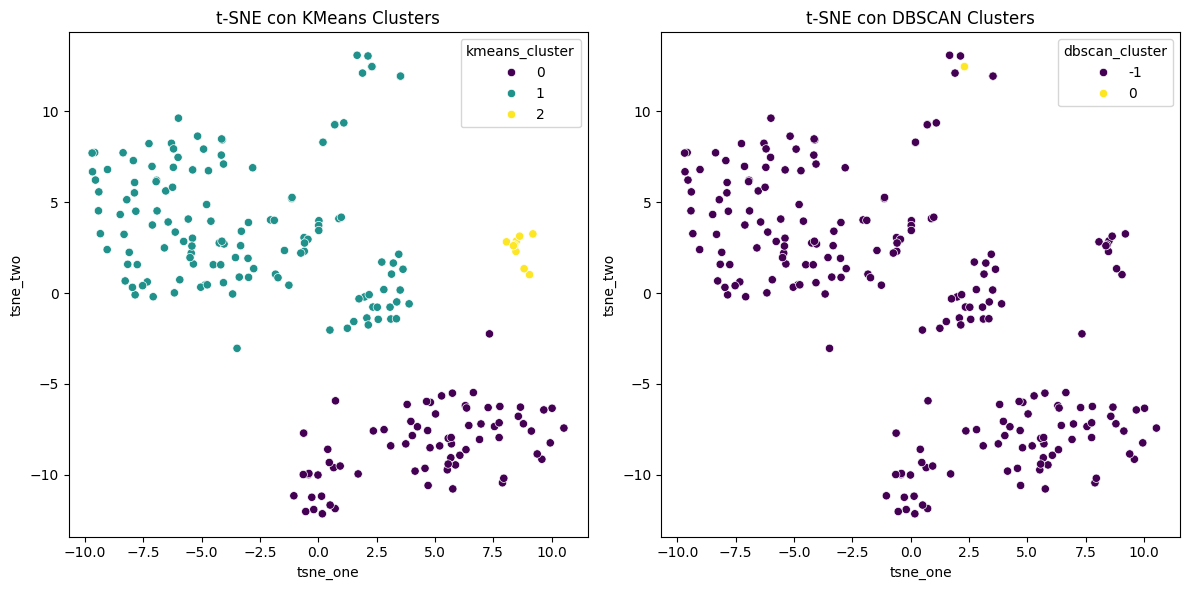

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Seleccionar solo columnas numéricas para clustering
# Excluir stay_id y hadm_id ya que son identificadores
numeric_cols = merged.select_dtypes(include=np.number).columns.tolist()
cols_to_exclude = ['stay_id', 'hadm_id']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Crear un sub-dataframe con solo las columnas numéricas seleccionadas
merged_numeric = merged[numeric_cols].copy()

# Manejar valores faltantes para clustering (imputación con la media)
# Puedes elegir otra estrategia de imputación si es necesario
imputer = SimpleImputer(strategy='mean')
merged_numeric_imputed = imputer.fit_transform(merged_numeric)
merged_numeric_imputed_df = pd.DataFrame(merged_numeric_imputed, columns=numeric_cols)


# Escalar los datos numéricos imputados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_numeric_imputed_df)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

# Aplicar KMeans
# Se puede experimentar con diferentes números de clusters (n_clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
merged['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Aplicar DBSCAN
# Se deben ajustar los parámetros eps y min_samples
dbscan = DBSCAN(eps=0.5, min_samples=5)
merged['dbscan_cluster'] = dbscan.fit_predict(scaled_data)


# Visualización con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
merged['pca_one'] = pca_result[:,0]
merged['pca_two'] = pca_result[:,1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='pca_one', y='pca_two', hue='kmeans_cluster', data=merged, palette='viridis')
plt.title('PCA con KMeans Clusters')

plt.subplot(1, 2, 2)
sns.scatterplot(x='pca_one', y='pca_two', hue='dbscan_cluster', data=merged, palette='viridis')
plt.title('PCA con DBSCAN Clusters')

plt.tight_layout()
plt.show()

# Visualización con t-SNE
# t-SNE es computacionalmente más costoso y es mejor aplicarlo a un número menor de componentes de PCA
# o directamente a los datos escalados si el dataset no es muy grande.
# Usaremos los datos escalados directamente aquí.
# Se pueden ajustar los parámetros n_components (usualmente 2 o 3) y perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_data)
merged['tsne_one'] = tsne_result[:,0]
merged['tsne_two'] = tsne_result[:,1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='tsne_one', y='tsne_two', hue='kmeans_cluster', data=merged, palette='viridis')
plt.title('t-SNE con KMeans Clusters')

plt.subplot(1, 2, 2)
sns.scatterplot(x='tsne_one', y='tsne_two', hue='dbscan_cluster', data=merged, palette='viridis')
plt.title('t-SNE con DBSCAN Clusters')

plt.tight_layout()
plt.show()